In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import afqinsight.augmentation as aug

/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#This notebook runs a simple autoencoder on just first tract of each AFQ dataset sample, and visualizes the difference the dropout value has on the best loss. 

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100

File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
class VE_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VE_one_tract, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.linear1 = nn.Linear(input_shape, 50)
        self.linear2 = nn.Linear(50, latent_dims)
        self.linear3 = nn.Linear(50, latent_dims)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        # print("input shape", x.shape)
        x = torch.flatten(x, start_dim=1)
        # print("flattened shape", x.shape)
        x = self.linear1(x)
        # print("linear1 shape", x.shape)
        x = self.activation(x)
        x = self.dropout(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Decoder_one_tract, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 50)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(50, input_shape)
        # self.batch_norm = nn.BatchNorm1d(50)
        # self.batch_norm2 = nn.BatchNorm1d(100)
        # self.linear3 = nn.Linear(100, input_shape)
  
    def forward(self, z):
        batch_size = z.size(0)
        x = self.linear1(z)
        x = self.relu(x)
        # x = self.batch_norm(x)  .
        x = self.linear2(x)
        # x = self.relu(x)
        # x = self.batch_norm2(x)
        # x = self.linear3(x)
        return x.view(batch_size, -1)

In [7]:
class VAE_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VAE_one_tract, self).__init__()
        self.encoder = VE_one_tract(input_shape, latent_dims, dropout=dropout)
        self.decoder = Decoder_one_tract(input_shape, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def reconstruction_loss(x, x_hat, kl_div=0.0, reduction="sum"):
    """
    Compute the reconstruction loss (MSE) and optionally add a KL term.
    
    Parameters
    ----------
    x : torch.Tensor
        Original input tensor.
    x_hat : torch.Tensor
        Reconstructed output from the autoencoder.
    kl_div : float
        KL divergence term (VAE only). Defaults to 0 for a standard autoencoder.
    reduction : str
        Reduction mode: "sum" or "mean". Defaults to "sum".
    
    Returns
    -------
    torch.Tensor
        Scalar loss value.
    """
    # e.g. use MSE loss
    recon_loss = F.mse_loss(x_hat, x, reduction=reduction)
    l1_loss = F.l1_loss(x_hat, x, reduction=reduction)
    total_loss = recon_loss + kl_div
    return total_loss

In [11]:
def random_train_multiple_tracts_experiment(
    self, train_data, val_data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE overall

    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0

        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            # For simplicity, using only the first tract in training
            tract_data = x[:, 0, :]

            # Apply jitter augmentation
            tract_data = tract_data.to(torch.float32).numpy()
            tract_data = aug.jitter(tract_data, sigma=sigma)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            # Compute RMSE for the batch
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

            # Backward pass
            loss.backward()
            opt.step()

            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                # For simplicity, using the first tract in validation as well
                tract_data = x[:, 0, :]

                # Apply jitter augmentation
                tract_data = tract_data.to(torch.float32).numpy()
                tract_data = aug.jitter(tract_data, sigma=sigma)
                tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

                # Forward pass
                x_hat = self(tract_data)

                # Compute RMSE for the batch
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)

        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        # Update best validation loss if improved
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss



Training with dropout = 0
Epoch 1, Train RMSE: 0.4094, Val RMSE: 0.2987
Epoch 2, Train RMSE: 0.2236, Val RMSE: 0.1484
Epoch 3, Train RMSE: 0.1063, Val RMSE: 0.0760
Epoch 4, Train RMSE: 0.0663, Val RMSE: 0.0581
Epoch 5, Train RMSE: 0.0556, Val RMSE: 0.0532
Epoch 6, Train RMSE: 0.0517, Val RMSE: 0.0506
Epoch 7, Train RMSE: 0.0505, Val RMSE: 0.0499
Epoch 8, Train RMSE: 0.0499, Val RMSE: 0.0495
Epoch 9, Train RMSE: 0.0494, Val RMSE: 0.0492
Epoch 10, Train RMSE: 0.0489, Val RMSE: 0.0488
Epoch 11, Train RMSE: 0.0487, Val RMSE: 0.0480
Epoch 12, Train RMSE: 0.0486, Val RMSE: 0.0484
Epoch 13, Train RMSE: 0.0484, Val RMSE: 0.0480
Epoch 14, Train RMSE: 0.0482, Val RMSE: 0.0483
Epoch 15, Train RMSE: 0.0481, Val RMSE: 0.0480
Epoch 16, Train RMSE: 0.0480, Val RMSE: 0.0477
Epoch 17, Train RMSE: 0.0480, Val RMSE: 0.0478
Epoch 18, Train RMSE: 0.0479, Val RMSE: 0.0475
Epoch 19, Train RMSE: 0.0478, Val RMSE: 0.0477
Epoch 20, Train RMSE: 0.0478, Val RMSE: 0.0473
Epoch 21, Train RMSE: 0.0477, Val RMSE: 0.

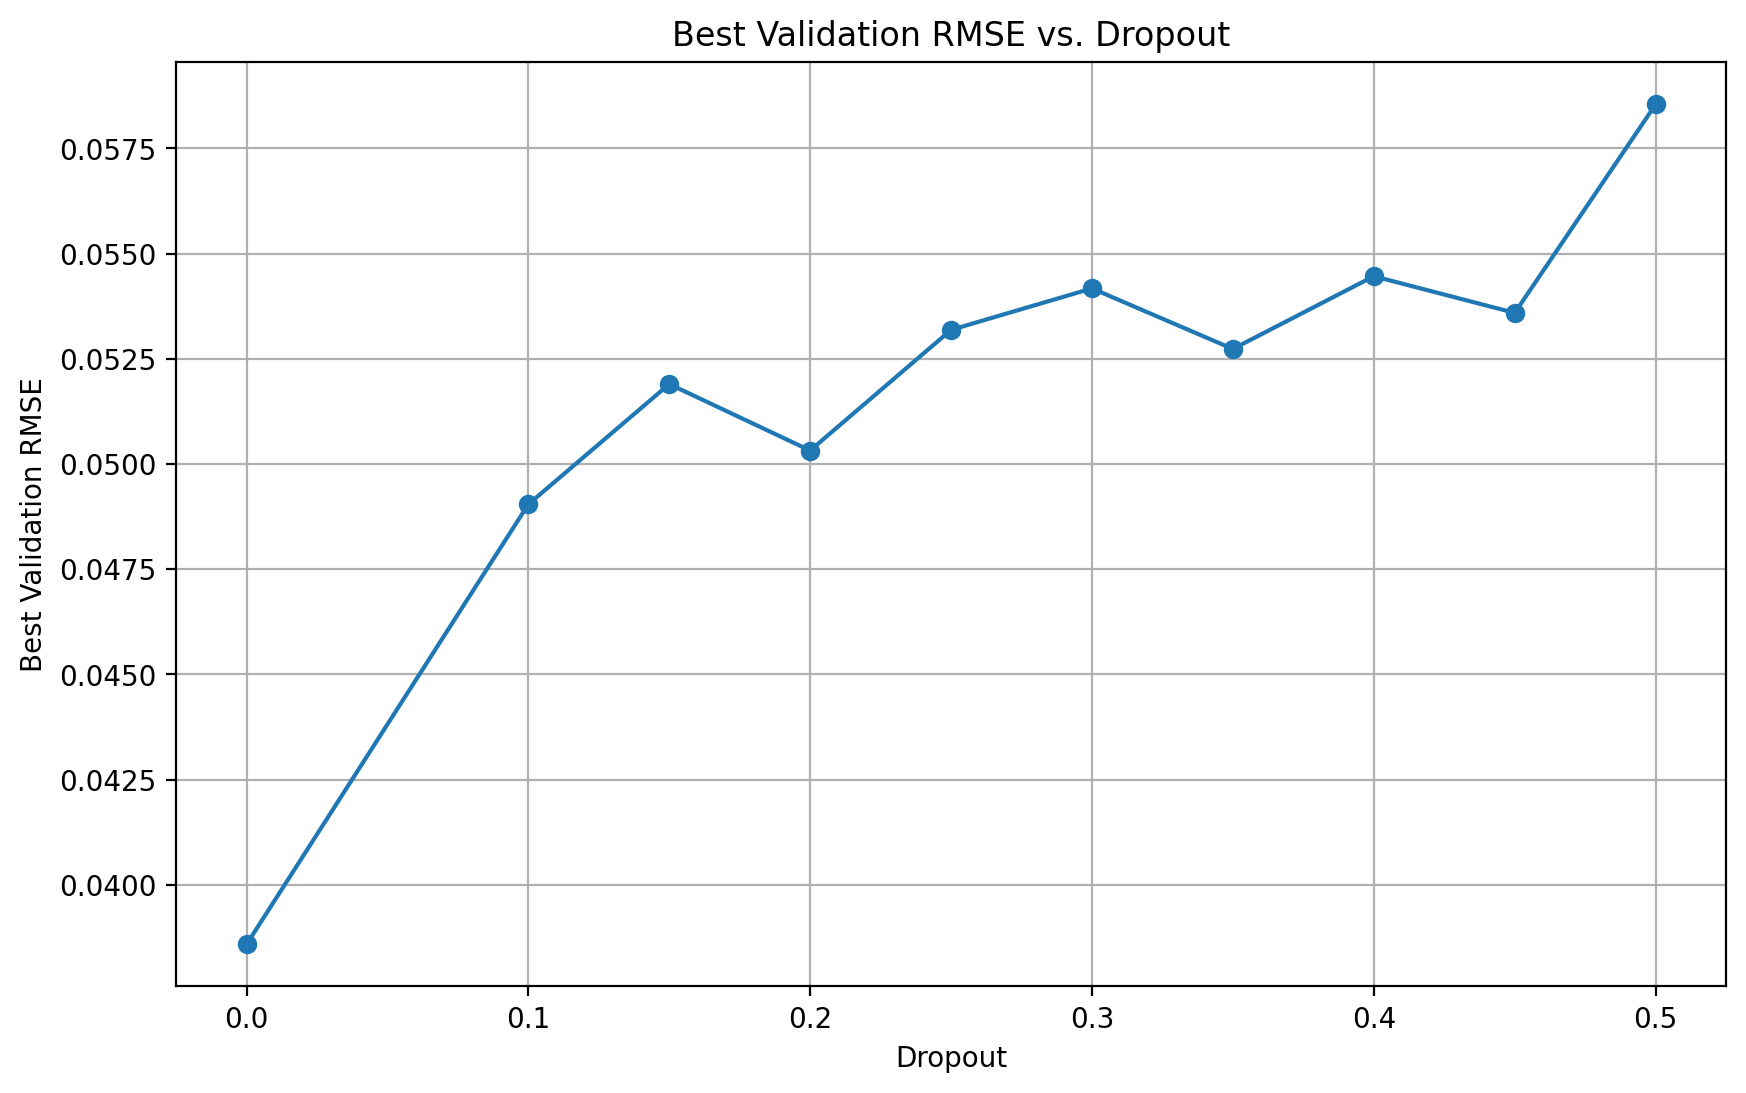

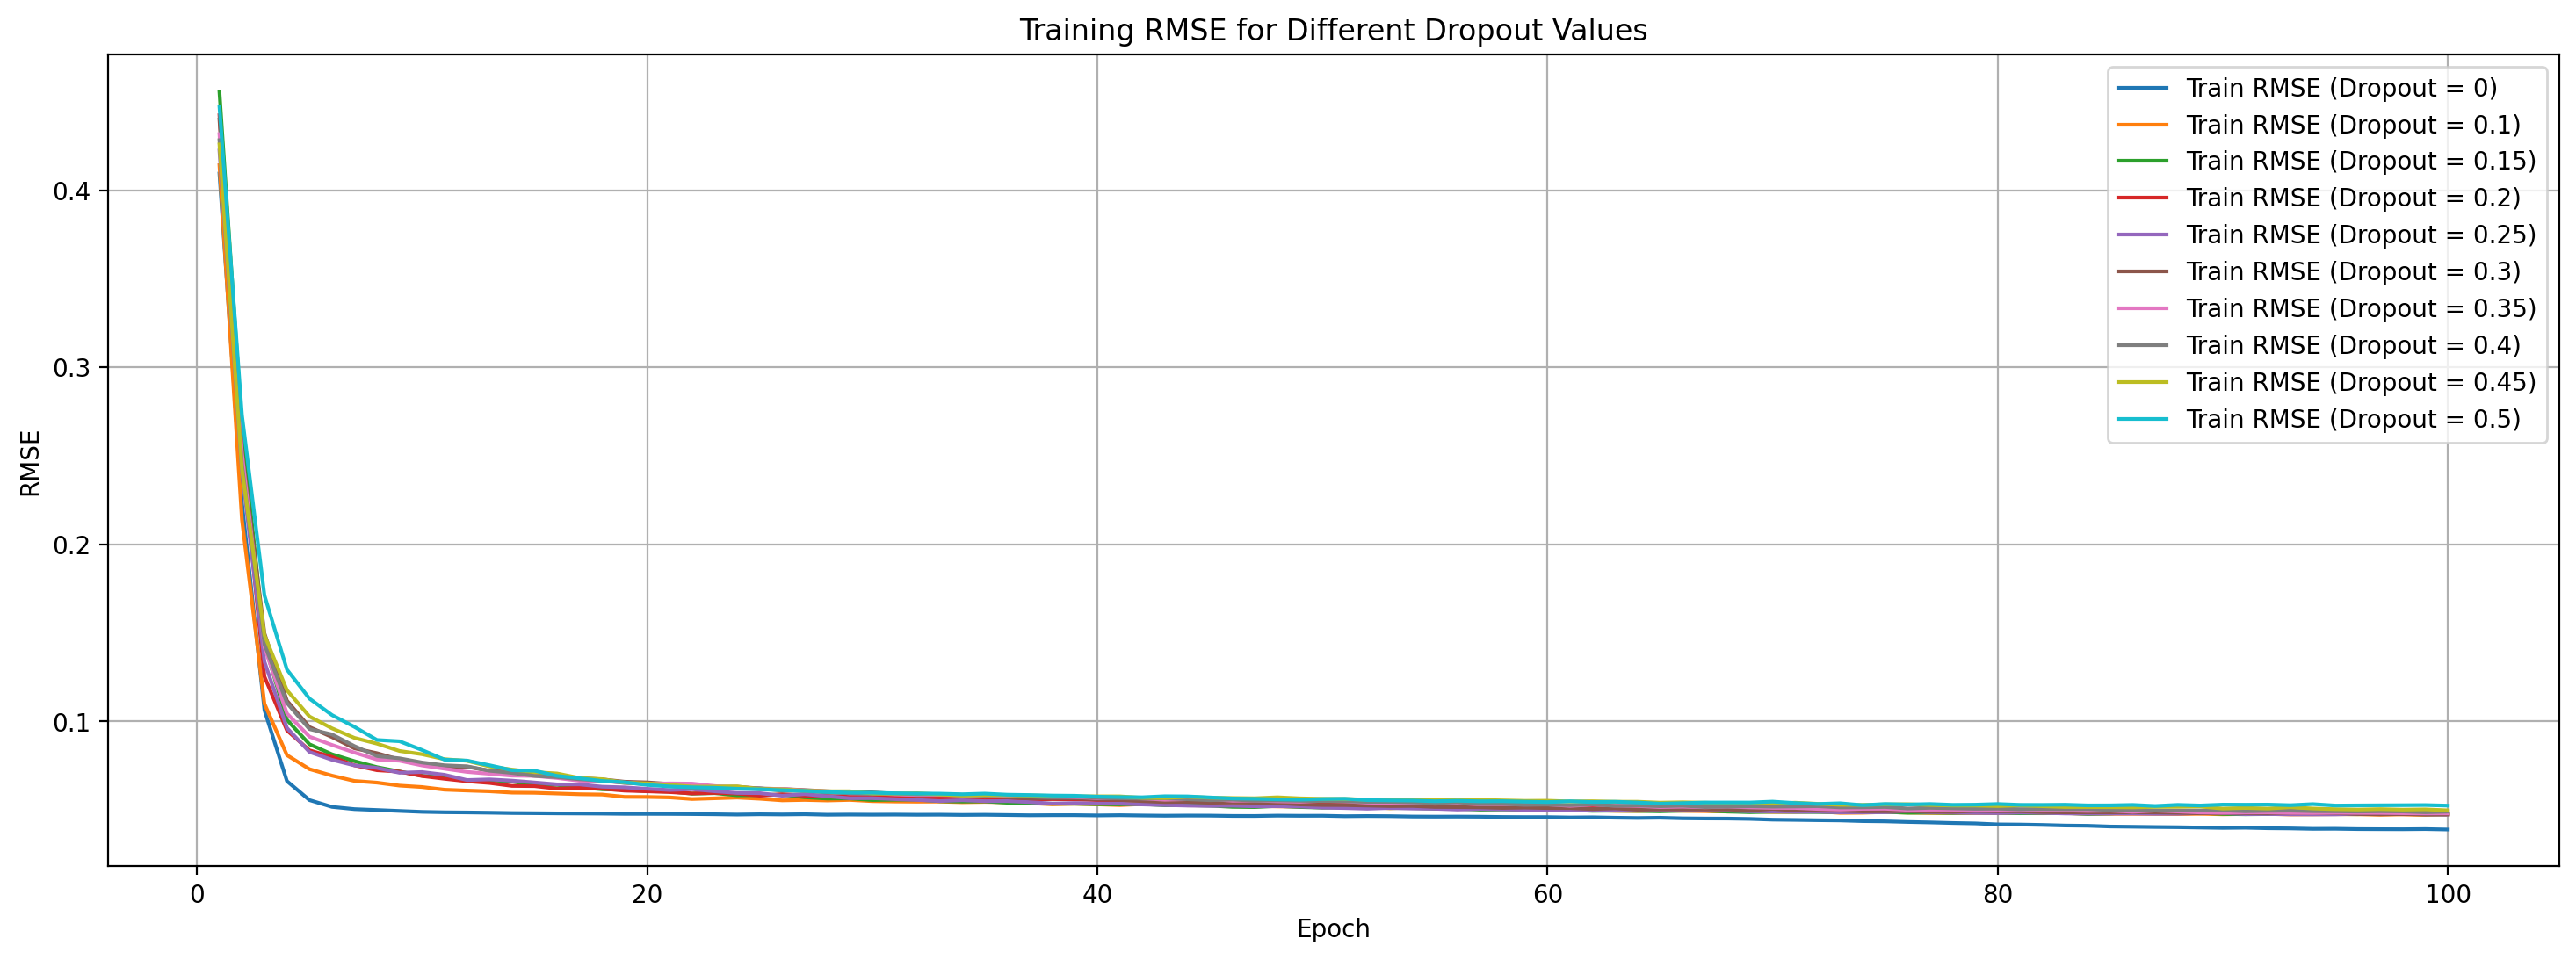

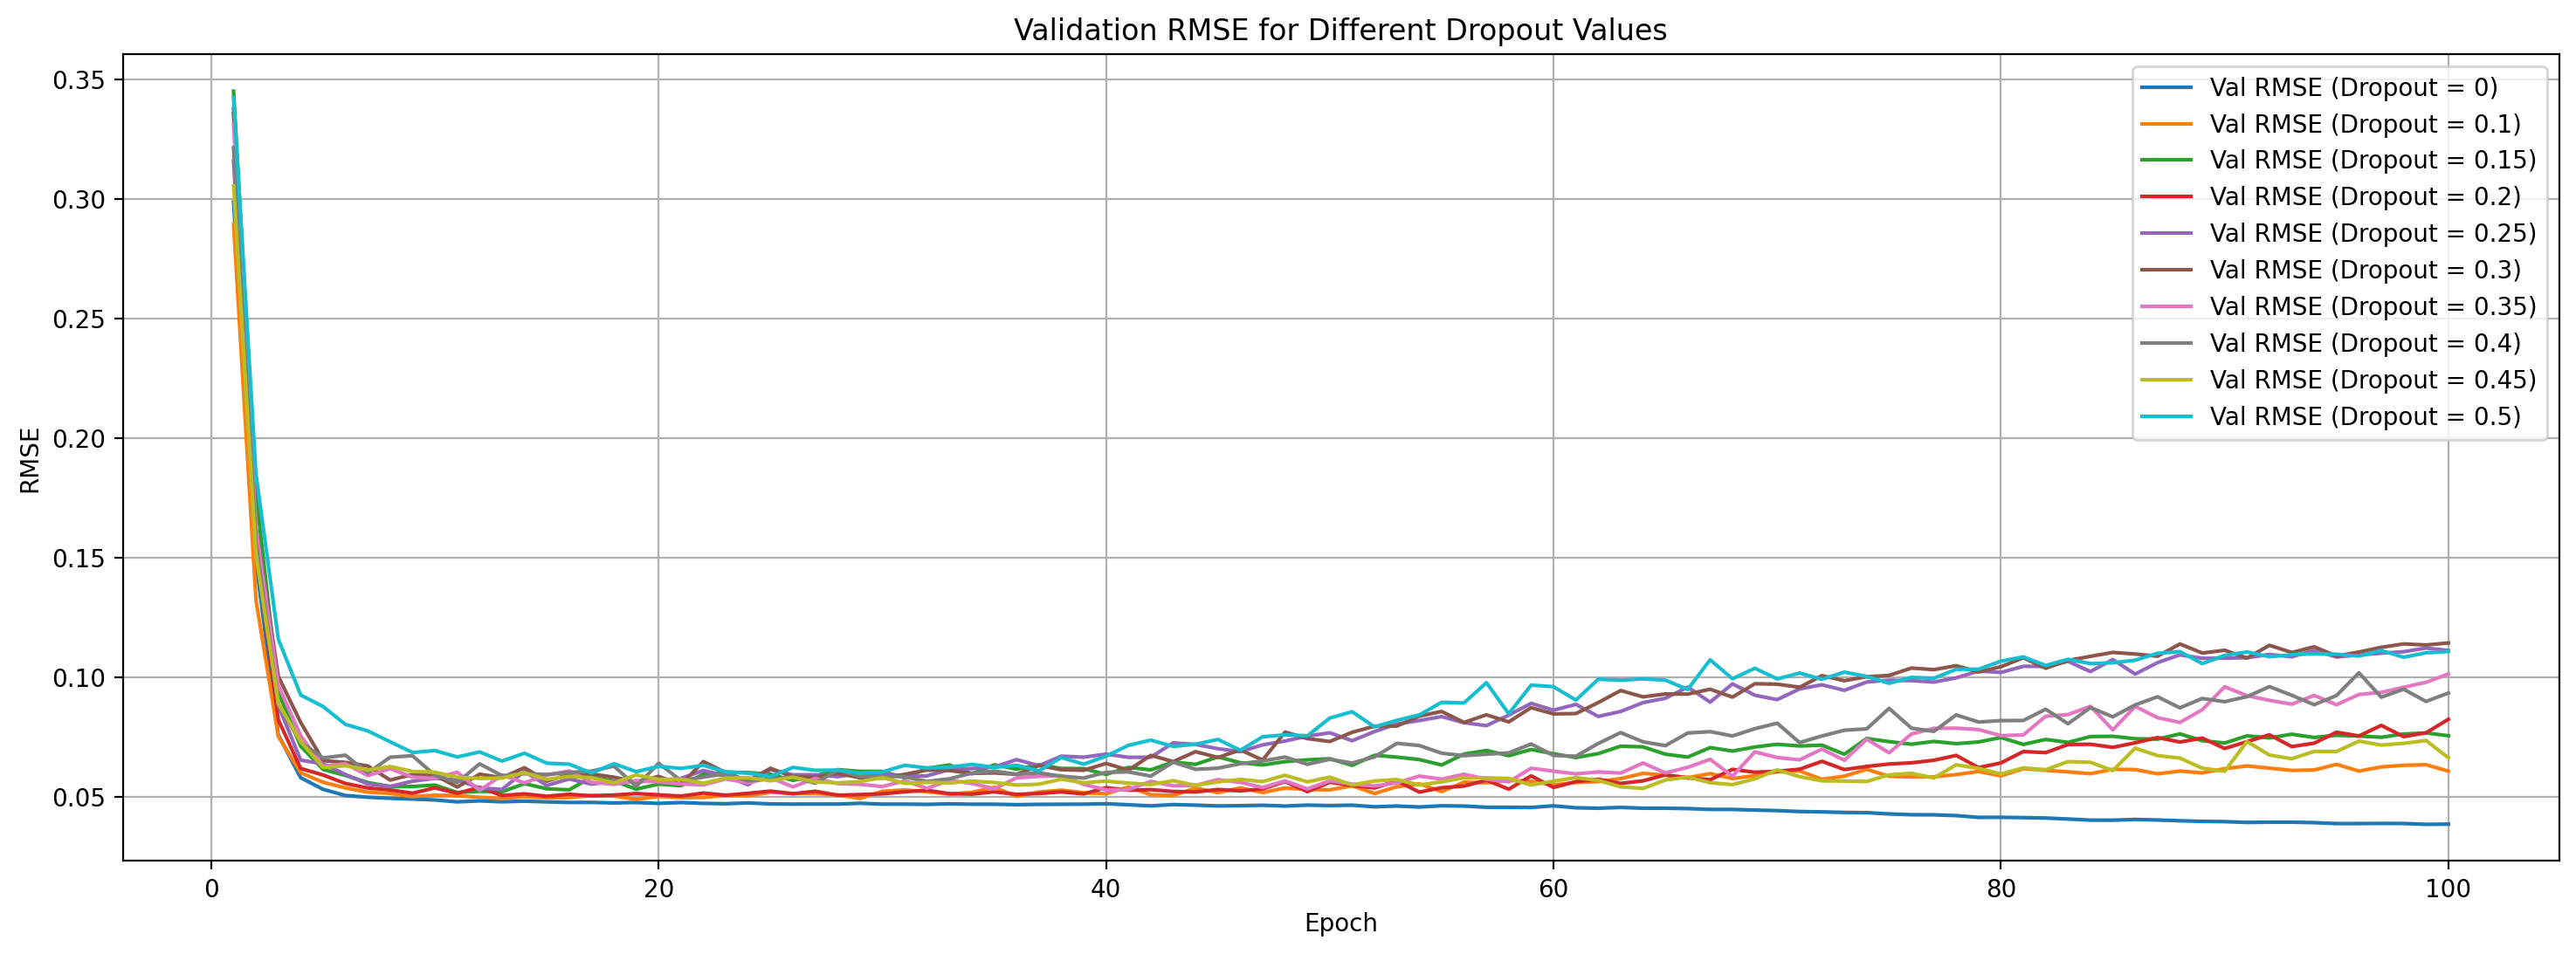

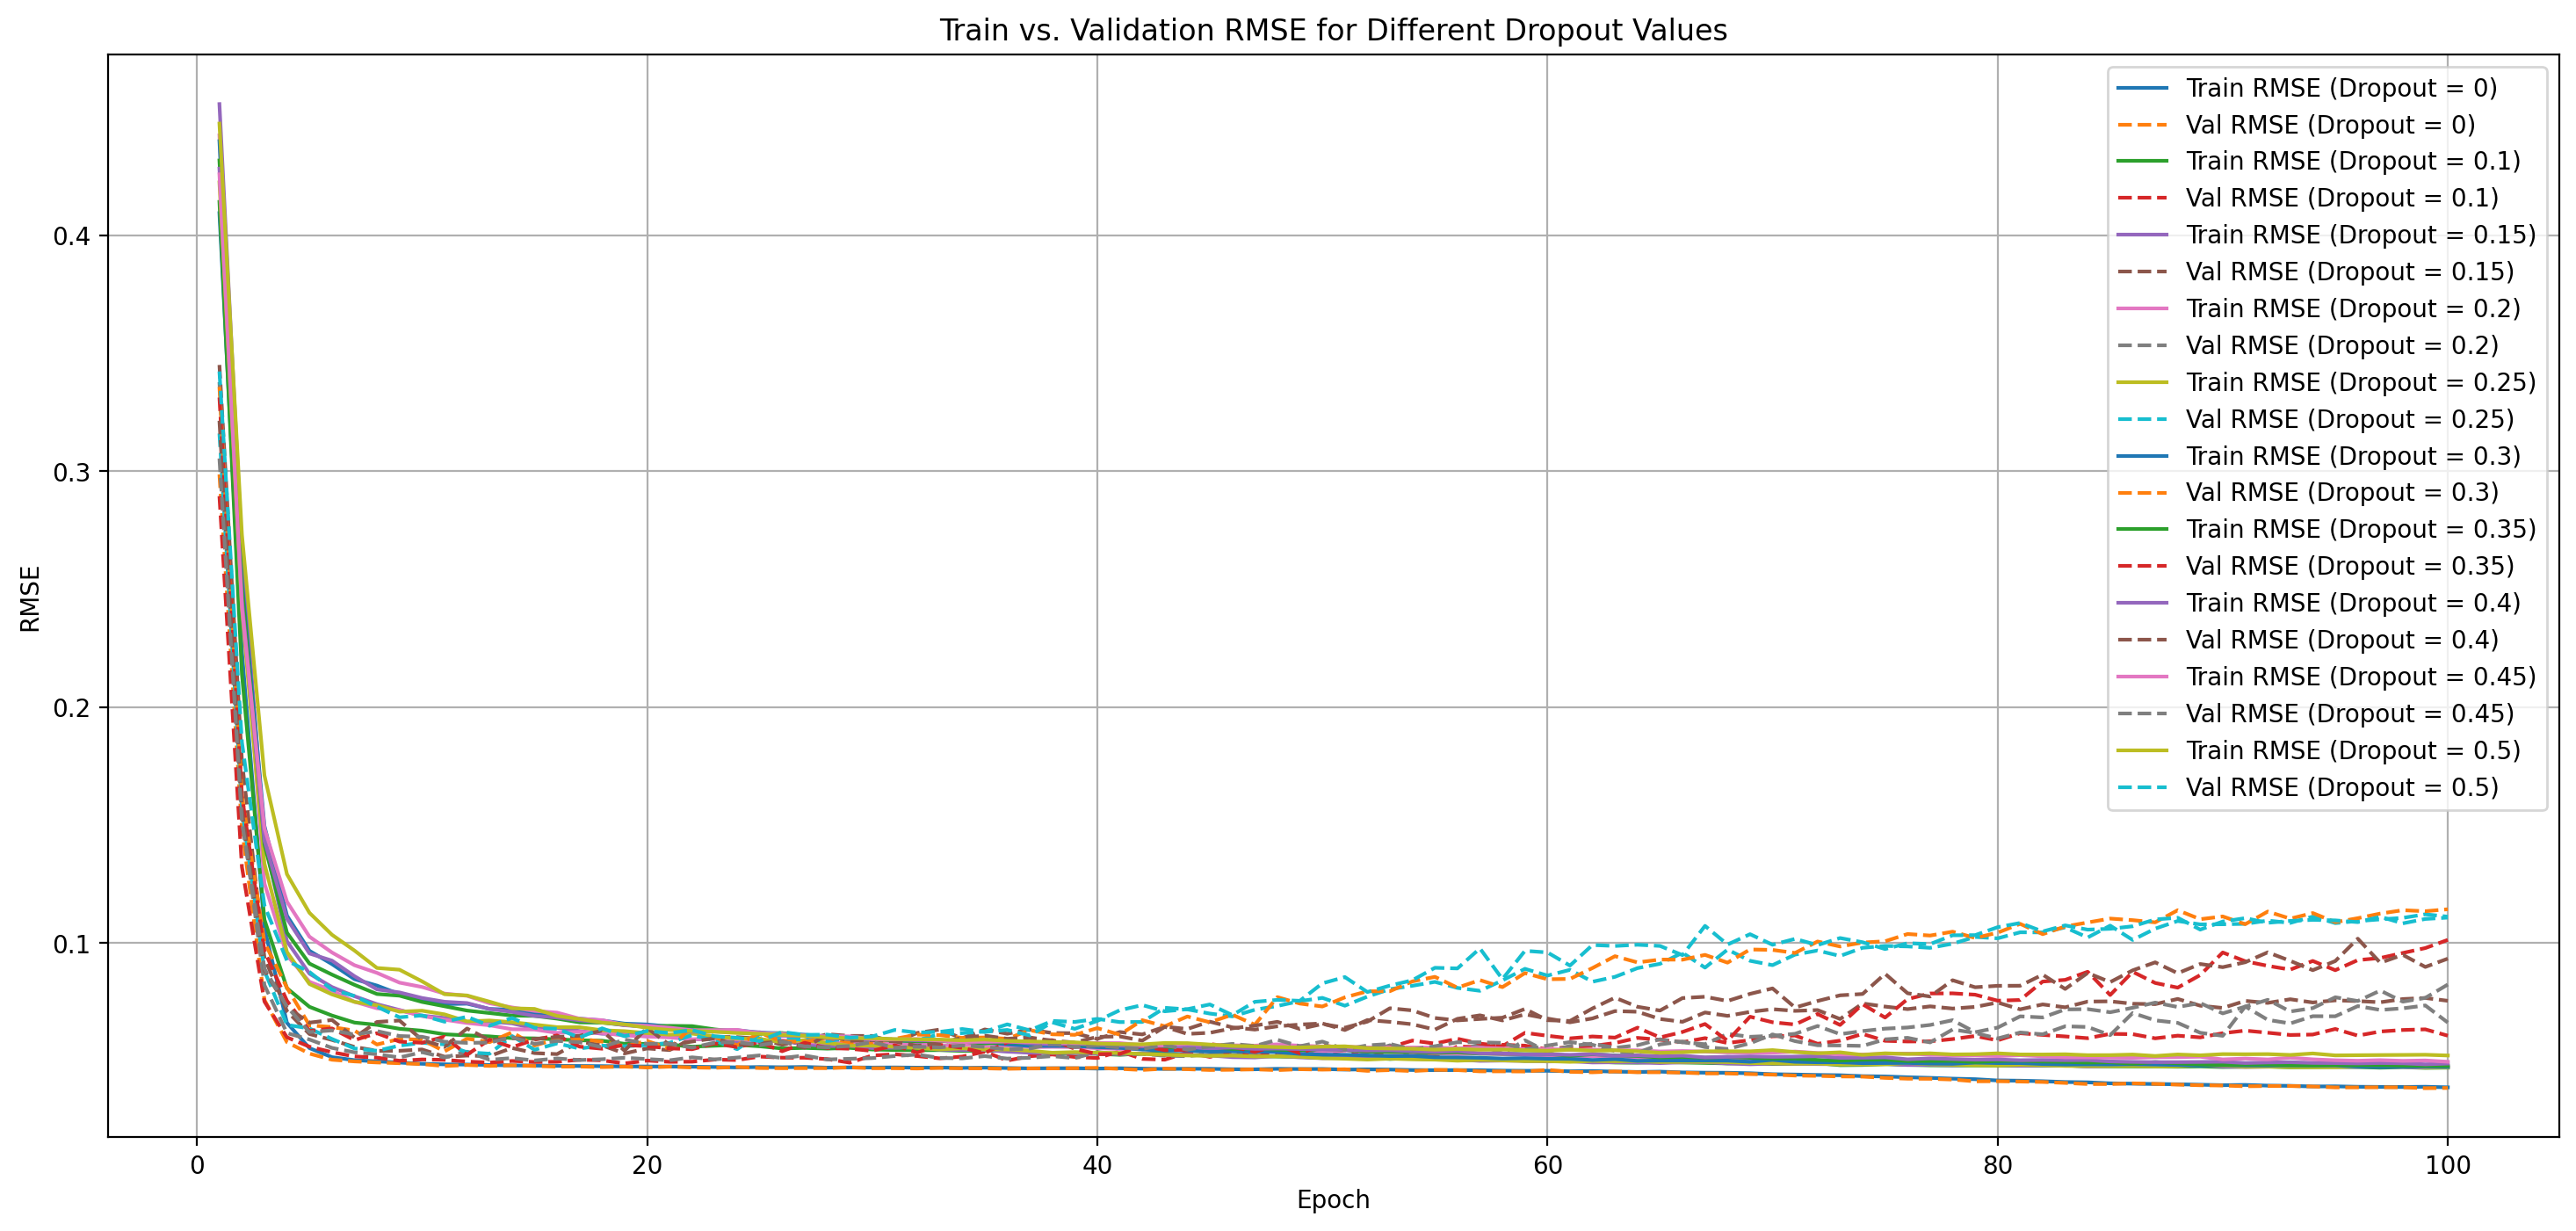

In [12]:
dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}

for dropout in dropout_values:
    print(f"\nTraining with dropout = {dropout}")
    vae_one_tract = VAE_one_tract(in_channels, latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse, best_val_loss = random_train_multiple_tracts_experiment(
        vae_one_tract, train_loader, val_loader, epochs=100, lr=1e-3, num_selected_tracts=8
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse
    best_val_results[dropout] = best_val_loss

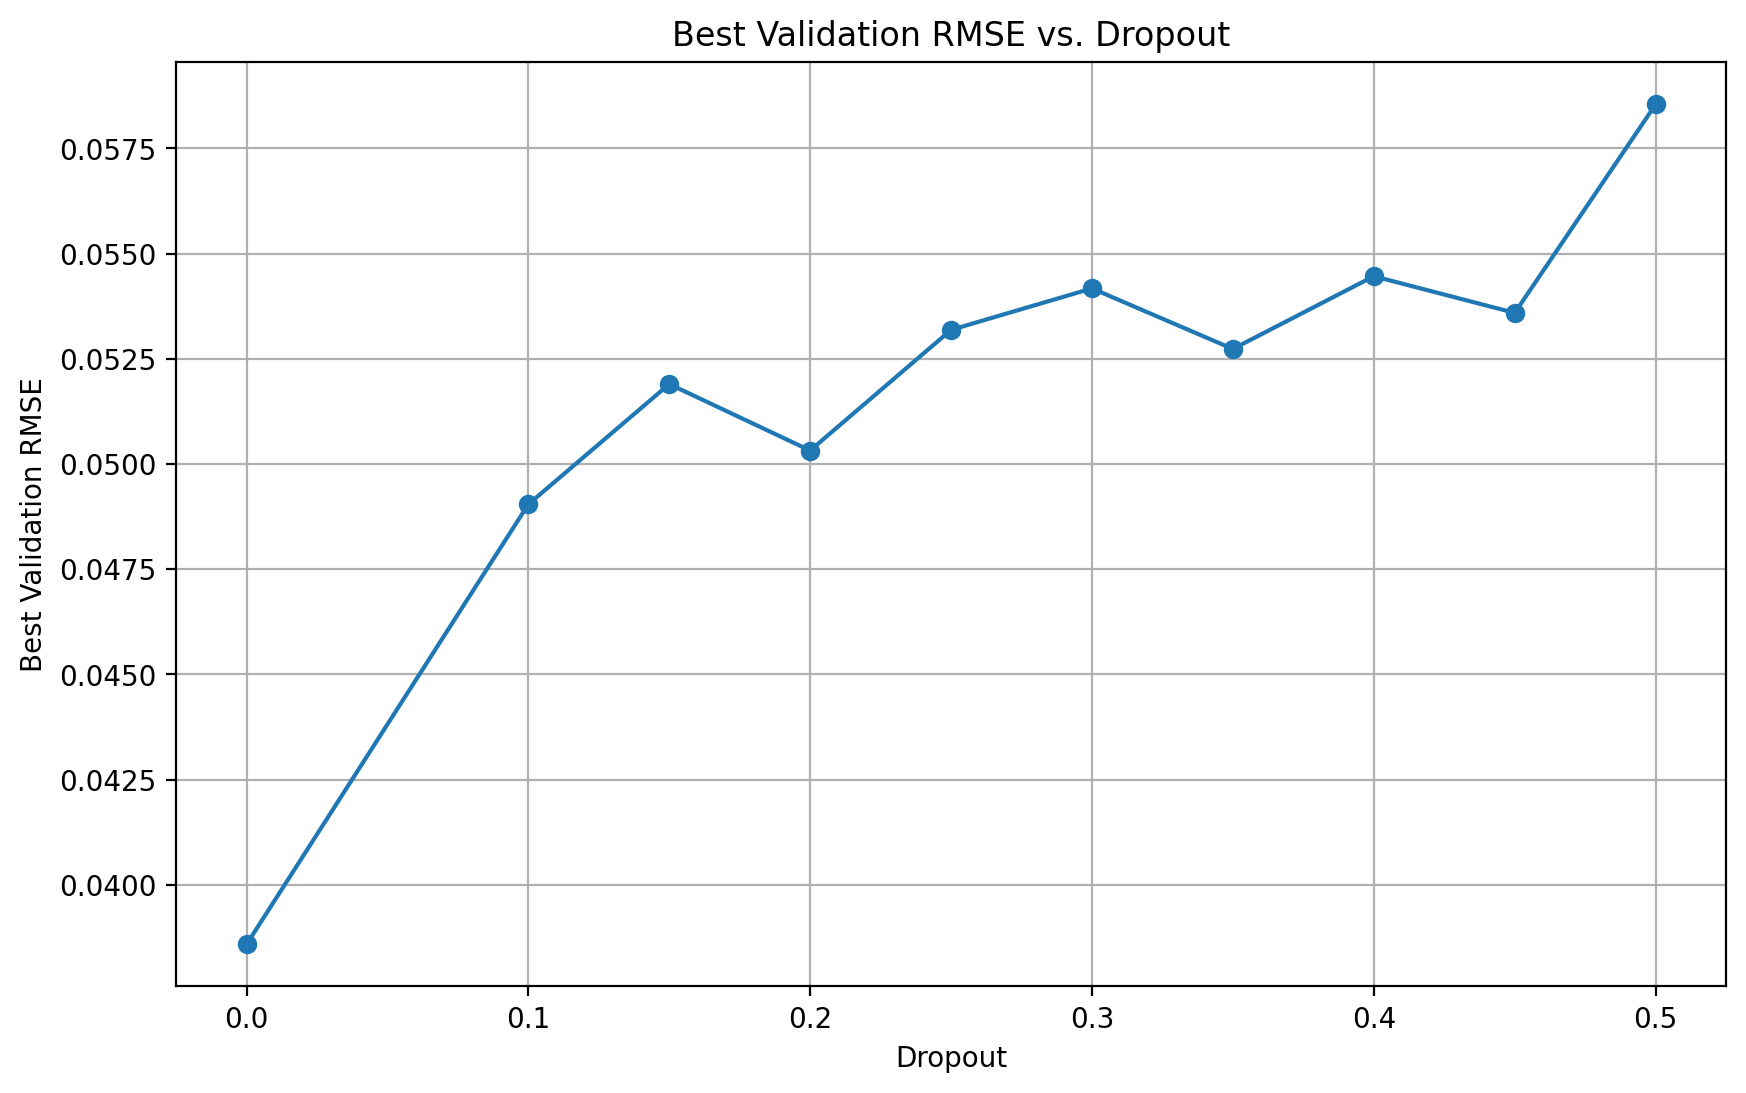

In [13]:
# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()

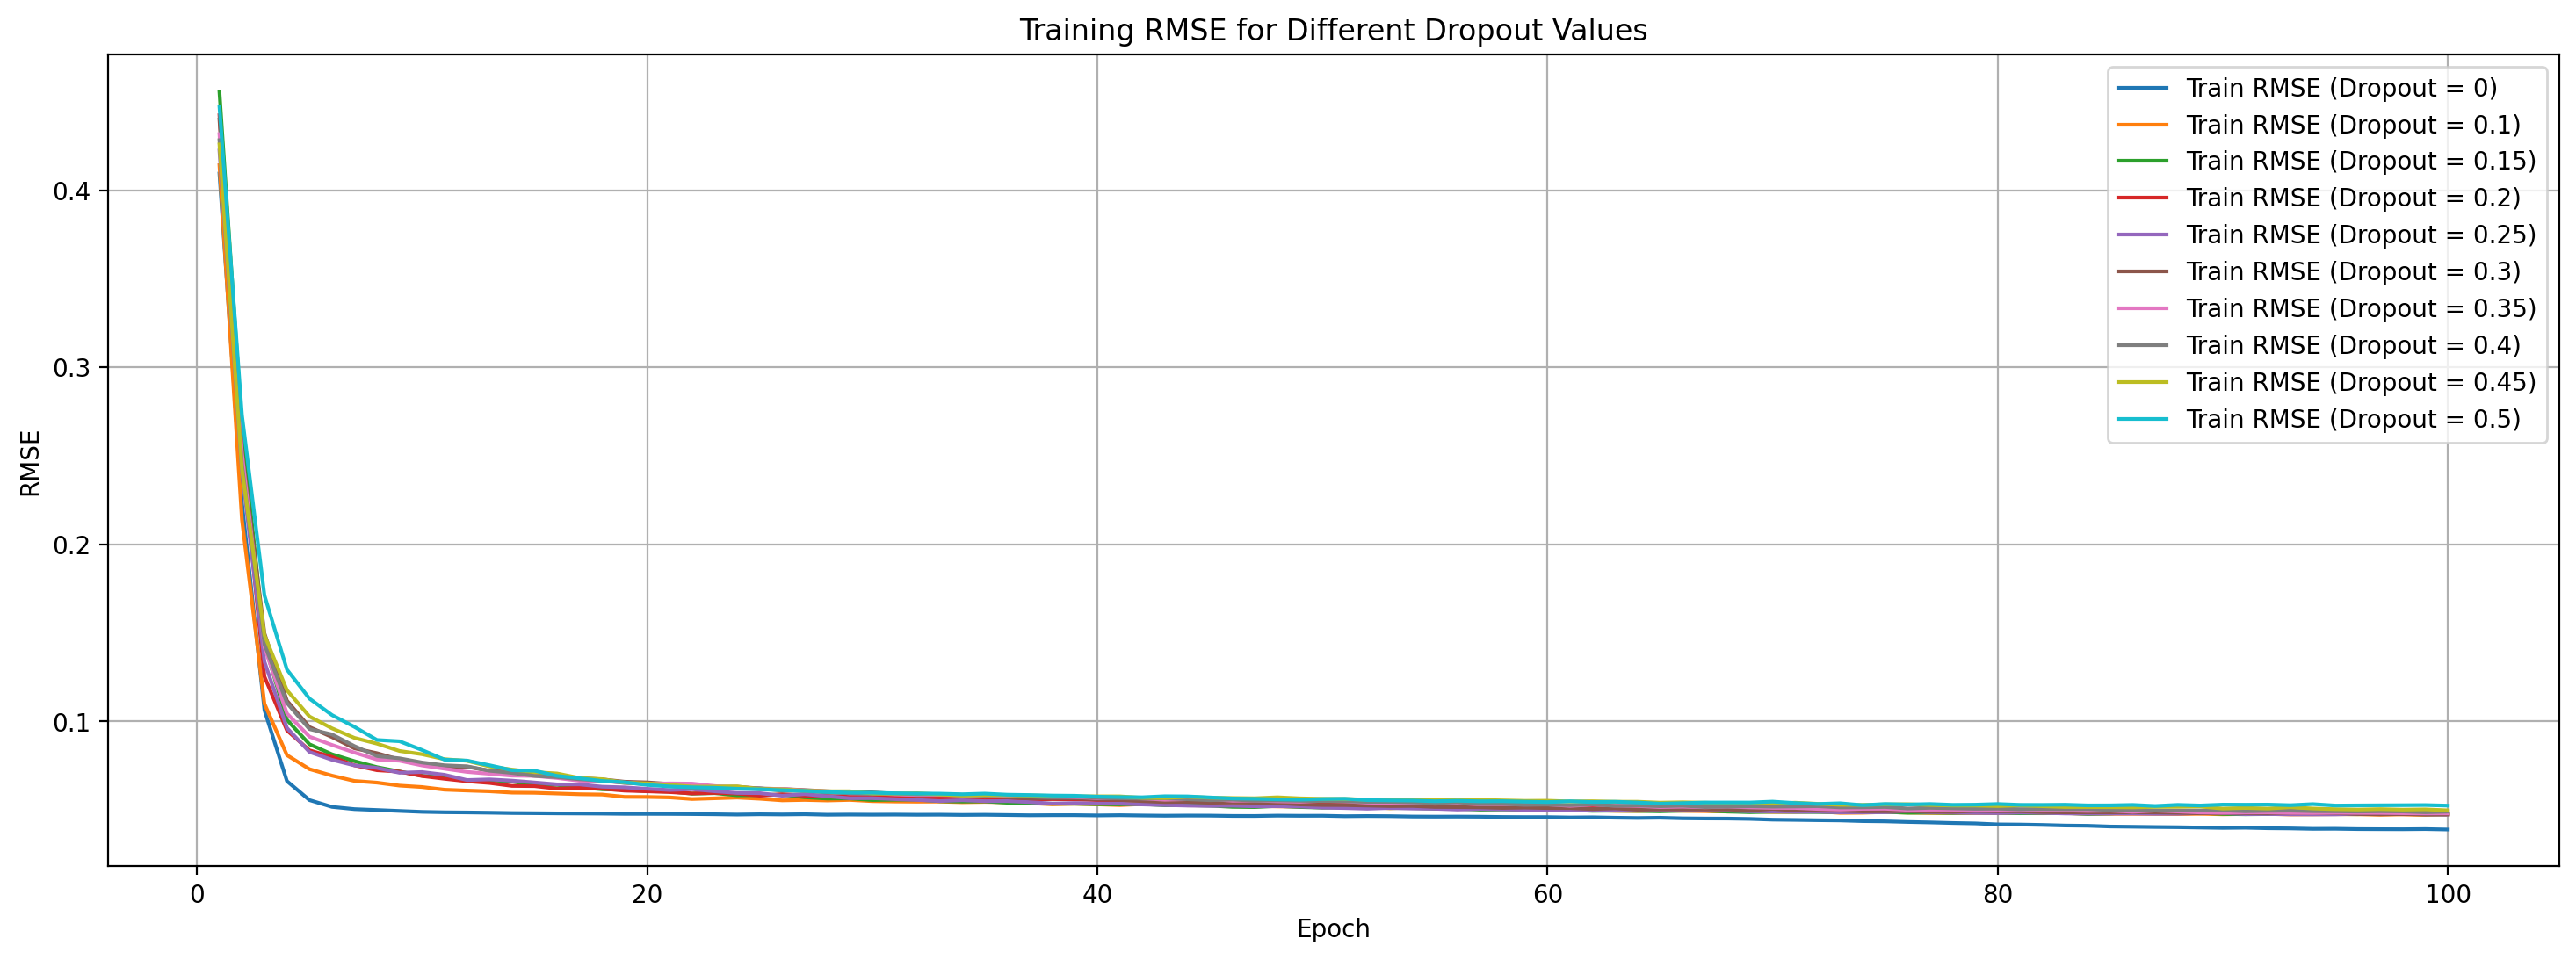

In [14]:
# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

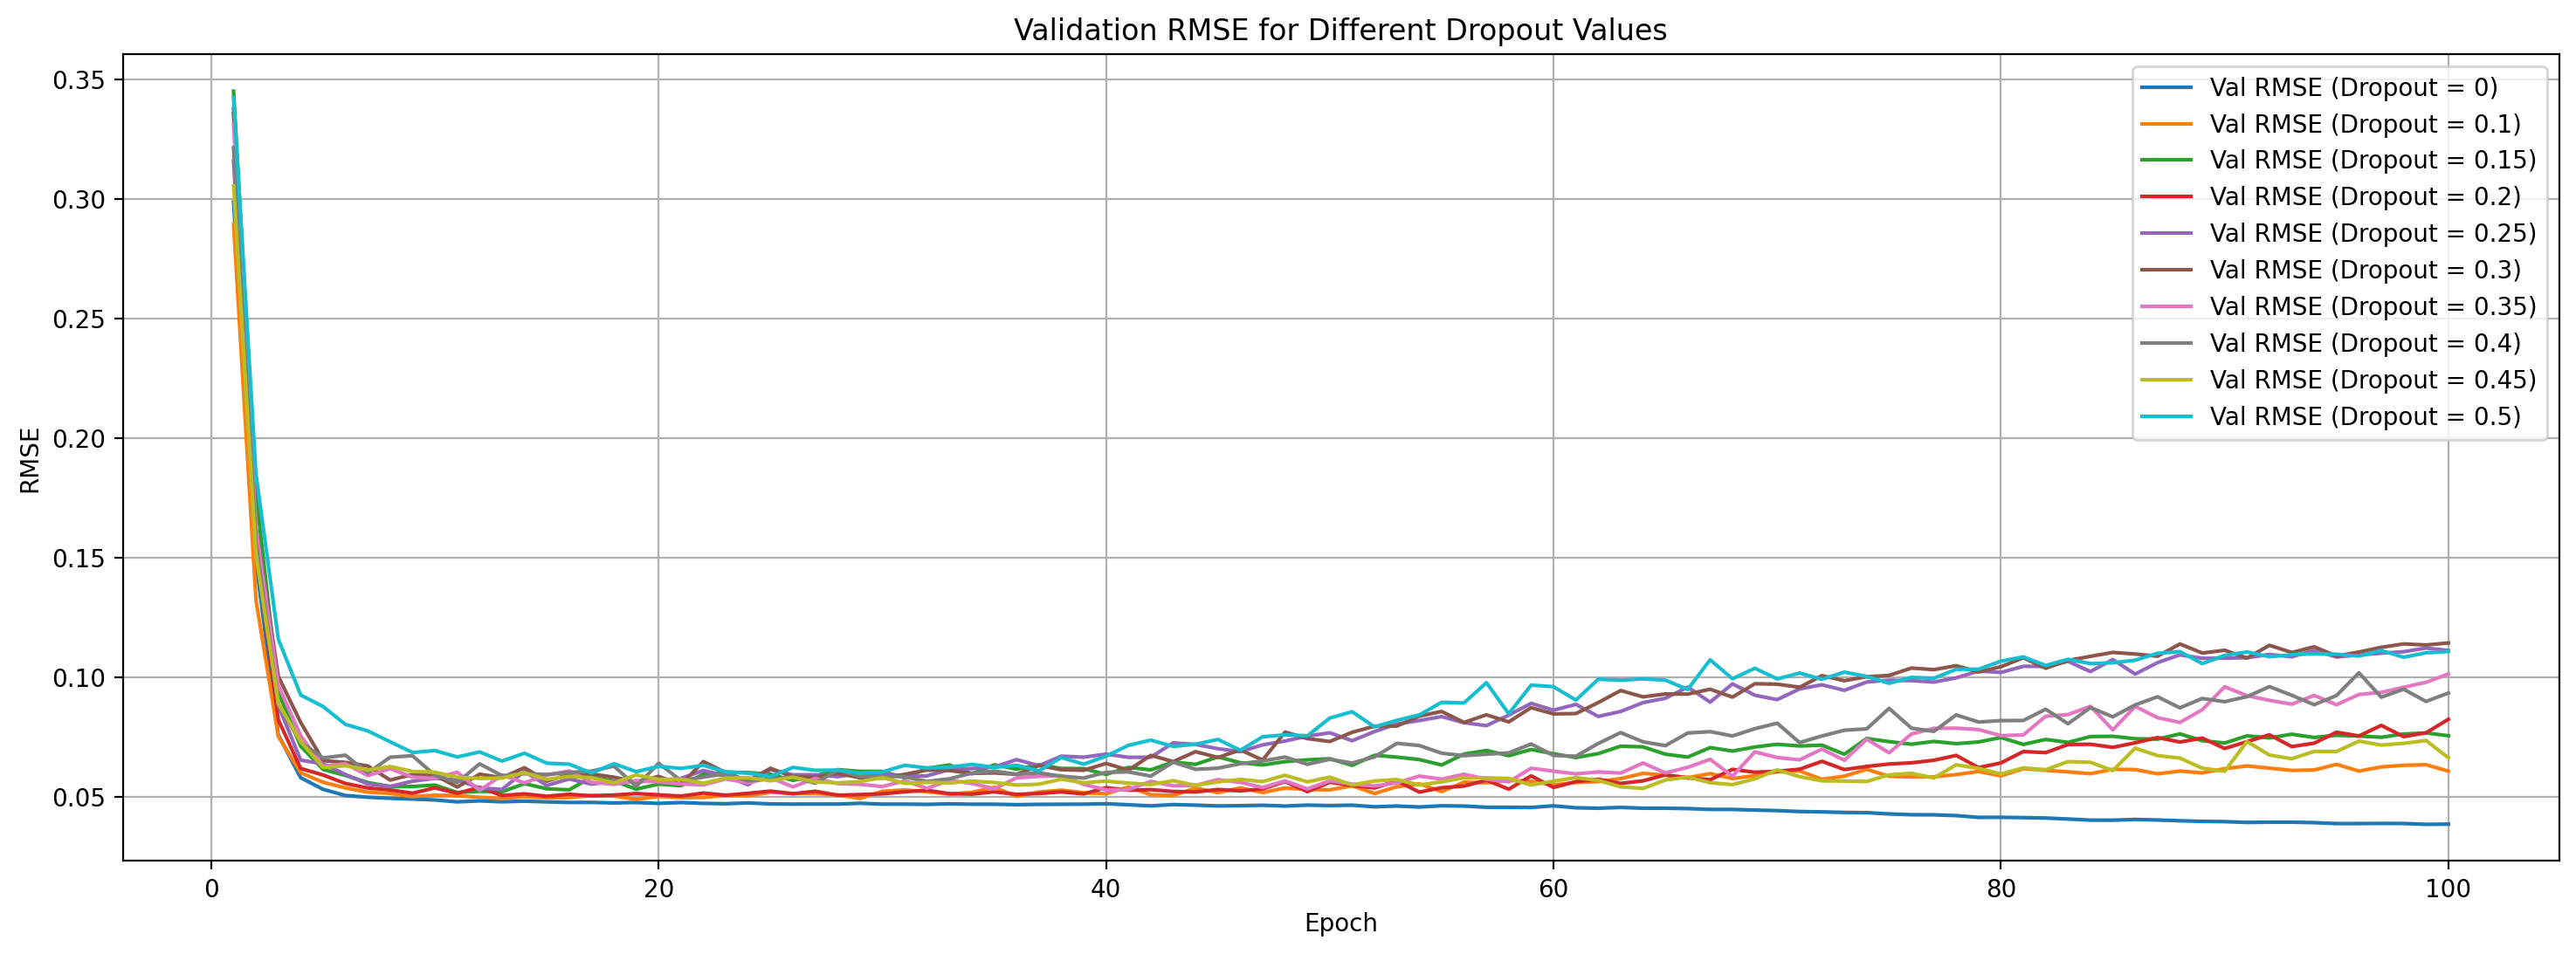

In [15]:
# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

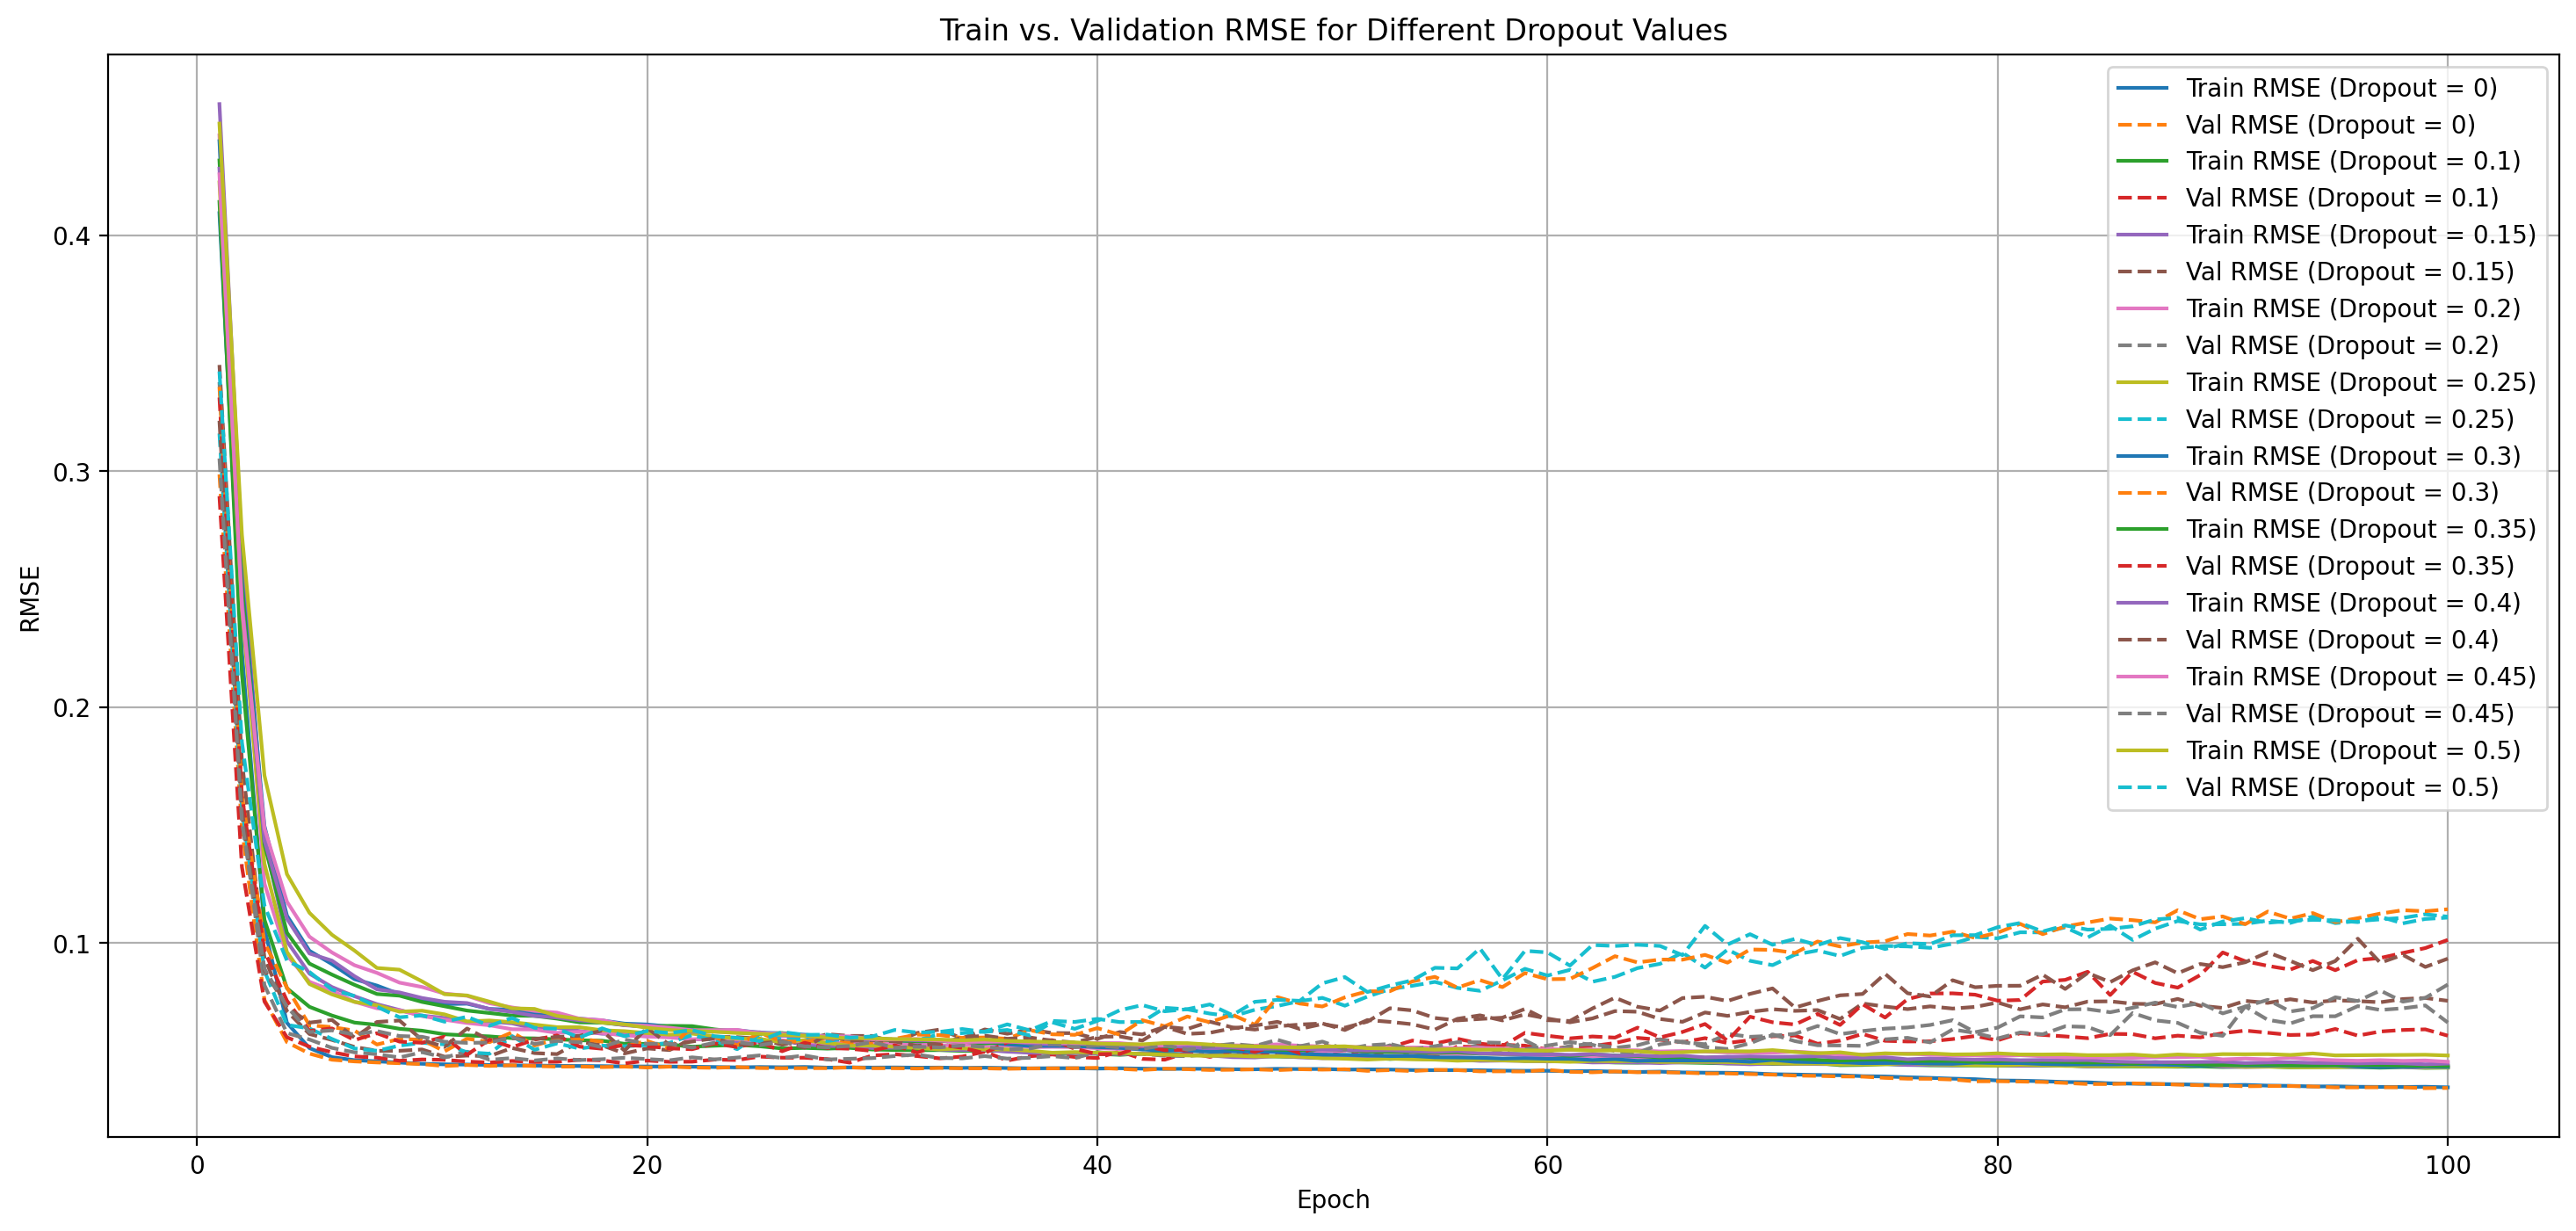

In [16]:
# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()
